## Creating a composite with 500hPa and "enhanced" monthly PNA index

In [14]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import time
import warnings

import scipy.stats

warnings.simplefilter(action='ignore', category=FutureWarning)

In [15]:
#opening the PNA index file. It is a monthly index from Jan 1948-Dec 2020
#it also removes the nan values which are -99 

path='/home/pdirmeye/classes/clim680_2022/CLIM_INDICES/'
file='pna.data'
index_name='pna'

df=pd.read_table(path+file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [16]:
#The date which it labels will be at the end of the month
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-31'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-31'
dates=pd.date_range(start=start_date,end=end_date,freq='M')
dates

DatetimeIndex(['1948-01-31', '1948-02-29', '1948-03-31', '1948-04-30',
               '1948-05-31', '1948-06-30', '1948-07-31', '1948-08-31',
               '1948-09-30', '1948-10-31',
               ...
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31'],
              dtype='datetime64[ns]', length=876, freq='M')

In [17]:
#unstacks the data 
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')

In [18]:
#puts all the data into a data array and shows the dataset
ds_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_index=ds_index.to_dataset(name='pna')
ds_index

<xarray.Dataset>
Dimensions:  (time: 876)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-31 1948-02-29 ... 2020-12-31
Data variables:
    pna      (time) float32 nan nan nan nan nan nan ... 1.2 1.8 0.59 nan nan nan

In [19]:
#slicing the dataset to match the length of the 500hPa dataset from era interim
ds_index_500= ds_index.sel(time=slice('1979-01-31','2019-08-31'))
ds_index_500

<xarray.Dataset>
Dimensions:  (time: 488)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-08-31
Data variables:
    pna      (time) float32 -1.54 -2.73 0.08 -0.15 1.27 ... -0.17 0.24 0.62 1.16

In [20]:
#Selecting the winter months of the pna index
months_to_extract = [12, 1, 2]  # December, January, and February

# Filter the dataset to include the specified months
ds_index_djf = ds_index_500.where(ds_index_500['time.month'].isin(months_to_extract), drop=True)
ds_index_djf

<xarray.Dataset>
Dimensions:  (time: 122)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-02-28
Data variables:
    pna      (time) float32 -1.54 -2.73 -0.68 -1.01 ... -1.67 0.56 0.42 -1.73

In [21]:
#These are the listed CAO from Smith 2019, changing them into a dataframe and sorting them 

all_cao_months= ['1983-12-31','1985-12-31','1989-12-31', '1995-12-31', '2000-12-31','2005-12-31','1981-01-31',
                '1982-01-31','1984-01-31','1985-01-31','1988-01-31','1989-01-31','1994-01-31','1996-01-31','2010-01-31',
                '1979-02-28','1980-02-29','2007-02-28','2015-02-28']

all_cao_months= pd.to_datetime(all_cao_months)

all_cao_months = all_cao_months.sort_values()
all_cao_months



DatetimeIndex(['1979-02-28', '1980-02-29', '1981-01-31', '1982-01-31',
               '1983-12-31', '1984-01-31', '1985-01-31', '1985-12-31',
               '1988-01-31', '1989-01-31', '1989-12-31', '1994-01-31',
               '1995-12-31', '1996-01-31', '2000-12-31', '2005-12-31',
               '2007-02-28', '2010-01-31', '2015-02-28'],
              dtype='datetime64[ns]', freq=None)

In [22]:
# Filter the dataset to include the specified months
ds_index_cao_months= ds_index_djf.sel(time= all_cao_months)
ds_index_cao_months

<xarray.Dataset>
Dimensions:  (time: 19)
Coordinates:
  * time     (time) datetime64[ns] 1979-02-28 1980-02-29 ... 2015-02-28
Data variables:
    pna      (time) float32 -2.73 2.03 2.46 -1.75 -0.61 ... 1.07 -0.42 0.96 0.49

In [23]:
#Creating an "enhanced" PNA. This isn't necessarily a real threshold.
#Using just to be able see if maybe cold air outbreaks are maybe more likely to happen if the PNA is "enhanced" 
#while also creating a neutral phase 

enhancedpostive_cao_months = ds_index_cao_months['pna'].where(ds_index_cao_months['pna']>1) # nans where false and unaltered where true if only first parameter given
enhancednegative_cao_months = ds_index_cao_months['pna'].where(ds_index_cao_months['pna']<-1)
neutral=ds_index_cao_months['pna'].where(np.logical_and(ds_index_cao_months['pna']>-1,
                                              ds_index_cao_months['pna']<1))

Positive:  5
Neutral:  11
:  3
[array(5), array(3), array(11)]


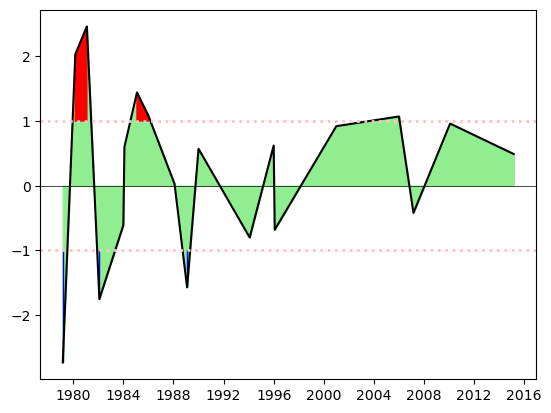

In [24]:
#MAking a little plot to see how it looks. More neutrals :|

print('Positive: ',enhancedpostive_cao_months.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)
print(': ',enhancednegative_cao_months.count(dim='time').values)

counts5=[enhancedpostive_cao_months.count(dim='time').values,
        enhancednegative_cao_months.count(dim='time').values,
        neutral.count(dim='time').values]
print(counts5)

plt.plot(ds_index_cao_months['time'],ds_index_cao_months['pna'],'k')
plt.fill_between(ds_index_cao_months['time'].values,ds_index_cao_months['pna'],color='lightgreen')
plt.fill_between(ds_index_cao_months['time'].values,enhancedpostive_cao_months,y2=1.0,color='red')
plt.fill_between(ds_index_cao_months['time'].values,enhancednegative_cao_months,y2=-1.0,color='blue')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(1,color='pink',linewidth=2,linestyle='dotted')
plt.axhline(-1,color='pink',linewidth=2,linestyle='dotted') ;

In [25]:
#Opening 500hPa dataset

file = "/scratch/kbarrag/clim680_dataset/mean/erai.z500.day.mean.1979-2019.nc"
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, time: 14853)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    z500     (time, lat, lon) float32 ...

In [26]:
# Create a monthly mean for every month of the daily data :|
z500_monthly = ds.resample(time='M').mean(dim='time')
z500_monthly

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, time: 488)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-08-31
Data variables:
    z500     (time, lat, lon) float32 5.754e+04 5.754e+04 ... 5.326e+04

In [27]:
#Extracting the winter months dec, jan, feb

months_to_extract = [12, 1, 2] 
ds_djf = z500_monthly.where(ds['time.month'].isin(months_to_extract), drop=True)
ds_djf

<xarray.Dataset>
Dimensions:  (time: 122, lat: 128, lon: 512)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-02-28
Data variables:
    z500     (time, lat, lon) float32 5.754e+04 5.754e+04 ... 4.877e+04

In [28]:
#creating a climatology from the winter months
ds_djf_monthly_climo=ds_djf.groupby("time.month").mean()
ds_djf_monthly_climo

<xarray.Dataset>
Dimensions:  (month: 3, lat: 128, lon: 512)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * month    (month) int64 1 2 12
Data variables:
    z500     (month, lat, lon) float32 5.751e+04 5.751e+04 ... 4.989e+04

In [29]:
#Here will get the anomaly
#from the anomaly will be able to see how PNA looks when the anomalies are a certain way

da_anoms_djf = ds_djf.groupby('time.month')- ds_djf_monthly_climo
da_anoms_djf

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, time: 122)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-02-28
    month    (time) int64 1 2 12 1 2 12 1 2 12 1 2 ... 1 2 12 1 2 12 1 2 12 1 2
Data variables:
    z500     (time, lat, lon) float32 29.15 29.52 30.49 ... -956.6 -957.5 -958.4

In [30]:
#Extracting the month again but making a data array
months_to_extract = [12, 1, 2] 
ds_cao = da_anoms_djf.z500.sel(time= all_cao_months)
ds_cao

<xarray.DataArray 'z500' (time: 19, lat: 128, lon: 512)>
array([[[   41.98828 ,    40.277344,    38.371094, ...,    45.40625 ,
            44.546875,    43.273438],
        [   42.210938,    40.28125 ,    38.51953 , ...,    46.01172 ,
            45.277344,    43.753906],
        [   42.35547 ,    40.375   ,    38.54297 , ...,    46.703125,
            45.95703 ,    44.046875],
        ...,
        [ -858.22656 ,  -857.2031  ,  -856.2031  , ...,  -861.39453 ,
          -860.3242  ,  -859.2656  ],
        [ -876.3633  ,  -875.9375  ,  -875.4922  , ...,  -877.7344  ,
          -877.2656  ,  -876.8203  ],
        [ -879.5156  ,  -879.4219  ,  -879.3711  , ...,  -879.7383  ,
          -879.6953  ,  -879.58594 ]],

       [[  -85.08594 ,   -84.66016 ,   -84.17969 , ...,   -85.00781 ,
           -85.140625,   -85.234375],
        [  -83.73828 ,   -82.82422 ,   -82.15234 , ...,   -83.61719 ,
           -83.18359 ,   -83.42578 ],
        [  -81.34766 ,   -80.58984 ,   -79.3125  , ...,   -82.15625 ,
           -81.07422 ,   -80.84375 ],
...
        [ -910.65625 ,  -909.21094 ,  -907.83203 , ...,  -915.0586  ,
          -913.5781  ,  -912.10547 ],
        [ -989.2383  ,  -988.4258  ,  -987.6406  , ...,  -991.7578  ,
          -990.9258  ,  -990.08203 ],
        [-1048.9688  , -1048.6758  , -1048.3945  , ..., -1049.8477  ,
         -1049.5625  , -1049.2539  ]],

       [[   34.80078 ,    36.945312,    37.121094, ...,    34.11328 ,
            34.0625  ,    33.73828 ],
        [   35.265625,    35.71875 ,    35.746094, ...,    35.51953 ,
            36.01953 ,    35.51172 ],
        [   36.578125,    36.476562,    36.75    , ...,    36.86328 ,
            37.16797 ,    36.679688],
        ...,
        [-1109.3164  , -1108.3828  , -1107.3984  , ..., -1111.9297  ,
         -1111.1133  , -1110.2227  ],
        [-1026.5508  , -1025.9844  , -1025.3672  , ..., -1028.1992  ,
         -1027.7031  , -1027.1602  ],
        [ -937.5703  ,  -937.34766 ,  -937.08594 , ...,  -938.2383  ,
          -937.9961  ,  -937.8008  ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-02-28 1980-02-29 ... 2015-02-28
    month    (time) int64 2 2 1 1 12 1 1 12 1 1 12 1 12 1 12 12 2 1 2

In [31]:
#Here matching the anomalies with the PNA pattern
#dropna= drops na values
enpostivephase_cao = ds_cao.sel(time=enhancedpostive_cao_months.dropna(dim='time')['time']).mean(dim='time')
ennegativephase_cao = ds_cao.sel(time=enhancednegative_cao_months.dropna(dim='time')['time']).mean(dim='time')
neutral_phase= ds_cao.sel(time=neutral.dropna(dim='time')['time']).mean(dim='time')

encomp_positive_cao = [enpostivephase_cao, ennegativephase_cao, neutral_phase]
encomp_positive_cao

[<xarray.DataArray 'z500' (lat: 128, lon: 512)>
 array([[-84.217186, -84.48672 , -84.82422 , ..., -83.973434, -84.17578 ,
         -84.22969 ],
        [-84.08984 , -83.97422 , -84.23047 , ..., -84.5875  , -84.48125 ,
         -84.28984 ],
        [-83.70078 , -83.430466, -83.55312 , ..., -84.59922 , -84.439064,
         -84.04844 ],
        ...,
        [323.02032 , 322.6289  , 322.21796 , ..., 324.3133  , 323.8625  ,
         323.43515 ],
        [333.84454 , 333.61874 , 333.41718 , ..., 334.5086  , 334.27032 ,
         334.0633  ],
        [339.09296 , 339.00235 , 338.9086  , ..., 339.35468 , 339.2758  ,
         339.17267 ]], dtype=float32)
 Coordinates:
   * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
   * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46,
 <xarray.DataArray 'z500' (lat: 128, lon: 512)>
 array([[ -34.928387,  -35.9375  ,  -37.015625, ...,  -32.039062,
          -33.02474 ,  -34.0625  ],
        [ -35.67448 ,  

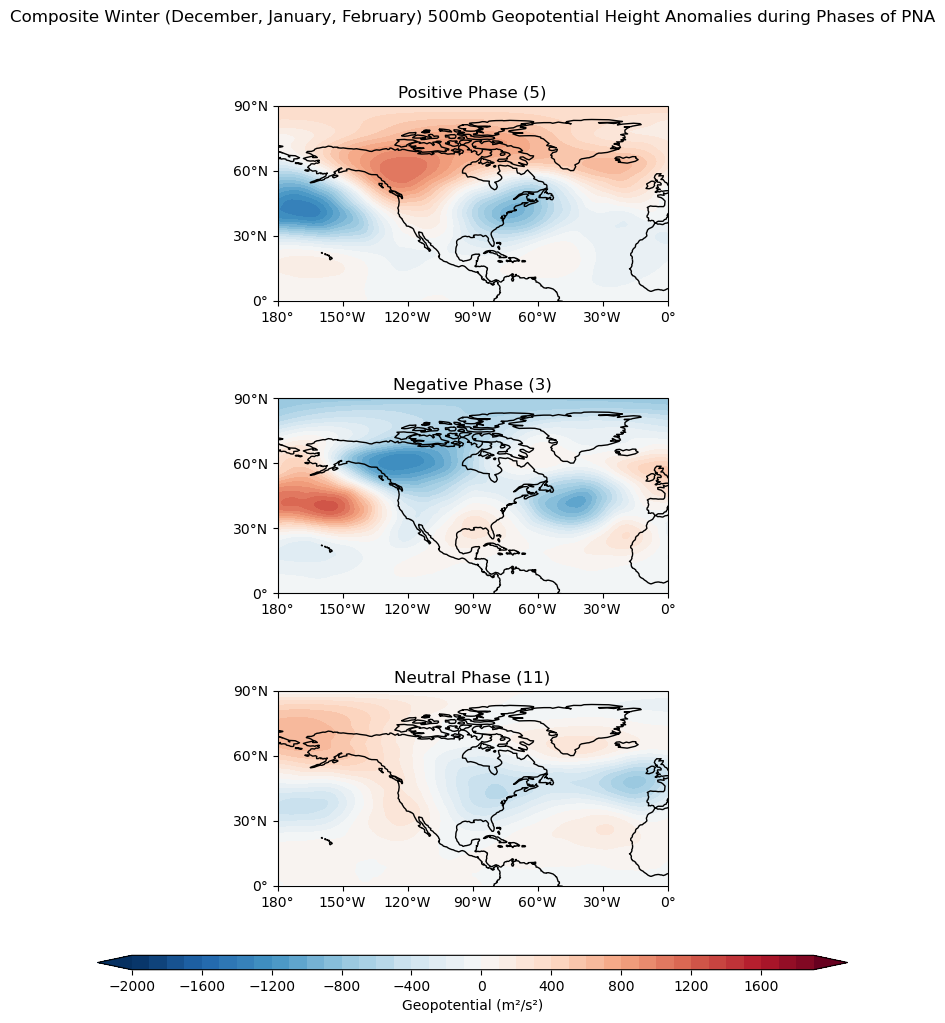

In [32]:
#Plotting the positive, negative and neutral phase of PNA index
#Plotting the 3 panels panels 

labels=['Positive Phase','Negative Phase','Neutral Phase']
clevs = np.arange(-2000,2000,100)


divnorm = colors.CenteredNorm(vcenter=0)


# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,12))



divnorm = colors.CenteredNorm(vcenter=0)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,month in enumerate(encomp_positive_cao):

        # Select the season
        data = encomp_positive_cao[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=encomp_positive_cao[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,encomp_positive_cao[i]['lat'],data,clevs,norm=divnorm,
                          transform = ccrs.PlateCarree(),
                          cmap='RdBu_r',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts5[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())   
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Geopotential (m\u00b2/s\u00b2)')

# Add a big title at the top
plt.suptitle('Composite Winter (December, January, February) 500mb Geopotential Height Anomalies during Phases of PNA') ;

In [33]:
#Creating a difference between the positive and negative against the neutral phase
diff_phase=[enpostivephase_cao-neutral_phase, 
             ennegativephase_cao-neutral_phase]

diff_phase


[<xarray.DataArray 'z500' (lat: 128, lon: 512)>
 array([[-74.79886 , -75.562355, -76.35547 , ..., -74.5956  , -74.775566,
         -74.77408 ],
        [-75.41762 , -75.4728  , -75.97869 , ..., -76.311226, -76.014626,
         -75.73906 ],
        [-76.512924, -76.29872 , -76.31591 , ..., -77.75689 , -77.45433 ,
         -76.928055],
        ...,
        [395.96494 , 395.8995  , 395.81525 , ..., 396.22736 , 396.13132 ,
         396.05057 ],
        [383.7515  , 383.74518 , 383.76447 , ..., 383.70923 , 383.72025 ,
         383.74866 ],
        [360.09863 , 360.11777 , 360.12592 , ..., 360.02158 , 360.05667 ,
         360.0704  ]], dtype=float32)
 Coordinates:
   * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
   * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46,
 <xarray.DataArray 'z500' (lat: 128, lon: 512)>
 array([[ -25.510063,  -27.013138,  -28.546875, ...,  -22.66122 ,
          -23.624525,  -24.606888],
        [ -27.00225 ,  

Text(0.5, 0.98, 'Composite PNA Phase Differences during Cold Air Outbreaks')

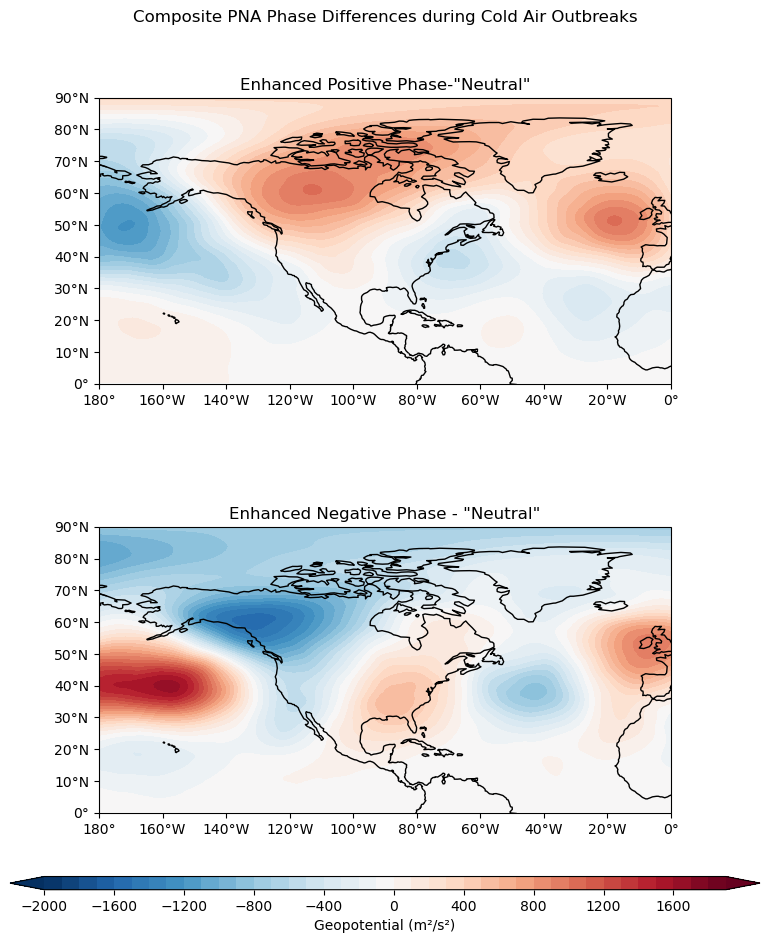

In [34]:
#Plotting the difference in a composite

labels=['Enhanced Positive Phase-"Neutral"','Enhanced Negative Phase - "Neutral"']
clevs=np.arange(-2000,2000,100)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(diff_phase):

        # Select the season
        data = diff_phase[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=diff_phase[i]['lon'])

        # Contour plot
        cs = axs[i].contourf(lons,diff_phase[i]['lat'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='RdBu_r',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,20), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree()) 
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Geopotential (m\u00b2/s\u00b2)')

# Add a big title at the top
plt.suptitle('Composite PNA Phase Differences during Cold Air Outbreaks')

In [35]:
#Now to plot the significance of the map
#Start of with a p-value. Well do 5%
p = 0.05 # 95% confidence level, or 5% likelihood that the result arose by chance

In [36]:
#Importing stats package
#then lining the positive, negative and neutral phase 

from scipy.stats import ttest_ind

positive_vals = ds_cao.sel(time=enhancedpostive_cao_months.dropna(dim='time')['time'])
negative_vals = ds_cao.sel(time=enhancednegative_cao_months.dropna(dim='time')['time'])
neutral_vals = ds_cao.sel(time=neutral.dropna(dim='time')['time'])

In [37]:
#Doing the t-test with the p-value
tstat,pval = ttest_ind(positive_vals, 
                neutral_vals, 
                equal_var = False)

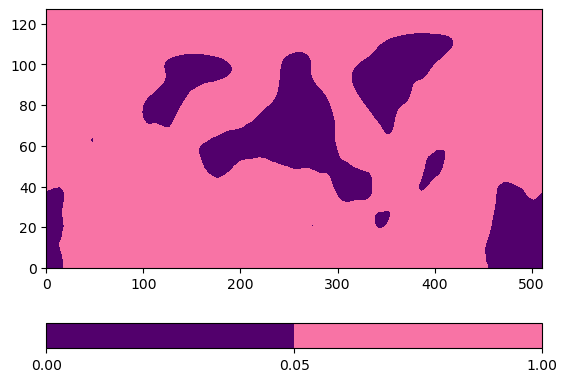

In [38]:
#Creating a map from the p-val
plt.contourf(pval,[0,0.05,1],cmap='RdPu_r') 
plt.colorbar(orientation='horizontal') ;

In [39]:
#Creating a mask from the map above
mask_diff = diff_phase[0].where(pval <= p)
mask_diff

<xarray.DataArray 'z500' (lat: 128, lon: 512)>
array([[-74.79886 , -75.562355, -76.35547 , ..., -74.5956  , -74.775566,
        -74.77408 ],
       [-75.41762 , -75.4728  , -75.97869 , ..., -76.311226, -76.014626,
        -75.73906 ],
       [-76.512924, -76.29872 , -76.31591 , ..., -77.75689 , -77.45433 ,
        -76.928055],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46

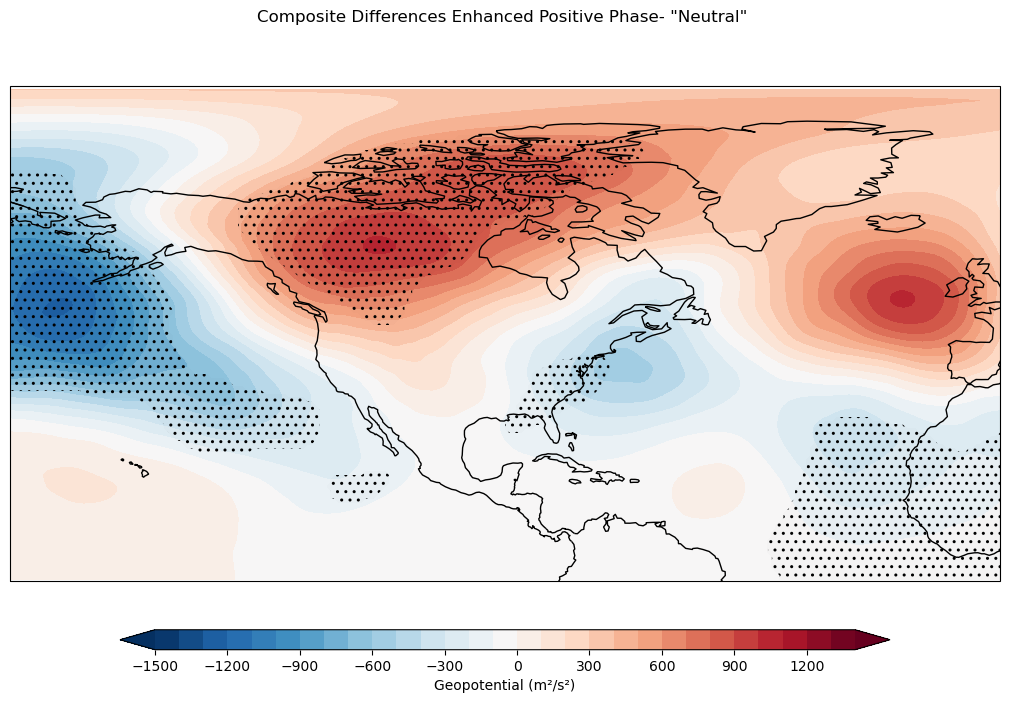

In [40]:
#Since PNA are associated with positive enhanced pna phase vs neutral phase trying to see the significane with it 

labels=['Positive Phase vs. Neutral']
clevs=np.arange(-1500,1500,100)
hatch_levs=[0]



fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8))
data=diff_phase[0]

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_phase[0]['lon'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_phase[0]['lon'])

# Contour plot
cs=axs.contourf(lons,diff_phase[0]['lat'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='RdBu_r',extend='both')


# Overlay of stippling the little black marks/dots
#shows areas that are significantly significant

ss=axs.contourf(lons,diff_phase[0]['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['none'],
                hatches=['..',''],extend='both',alpha=0.01)

# Draw the coastines for each subplot
axs.coastlines()
axs.set_extent([-180, 0, 90, 0], ccrs.PlateCarree()) 
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.18, 0.7, 0.025])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Geopotential (m\u00b2/s\u00b2)')

# Add a big title at the top
plt.suptitle('Composite Differences Enhanced Positive Phase- "Neutral" ')

plt.savefig('stats_ttest.png')